<a href="https://colab.research.google.com/github/abrahammathews2000/ViT-TensorFlow-Implementation/blob/main/ViT_TensorFlow_Implementation_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**These notebook describes the different steps involved in the Vision Transformer**

In [ ]:
# Update TensorFlow to 2.16
!pip install --upgrade tensorflow

In [ ]:
# Load the required libraried
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.16.1


In [ ]:
# Load the dataset
cifar10 = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

print("train_images.shape =", train_images.shape)
print("train_labels.shape =", train_labels.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
train_images.shape = (50000, 32, 32, 3)
train_labels.shape = (50000, 1)


In [ ]:
# List containing classification labels
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

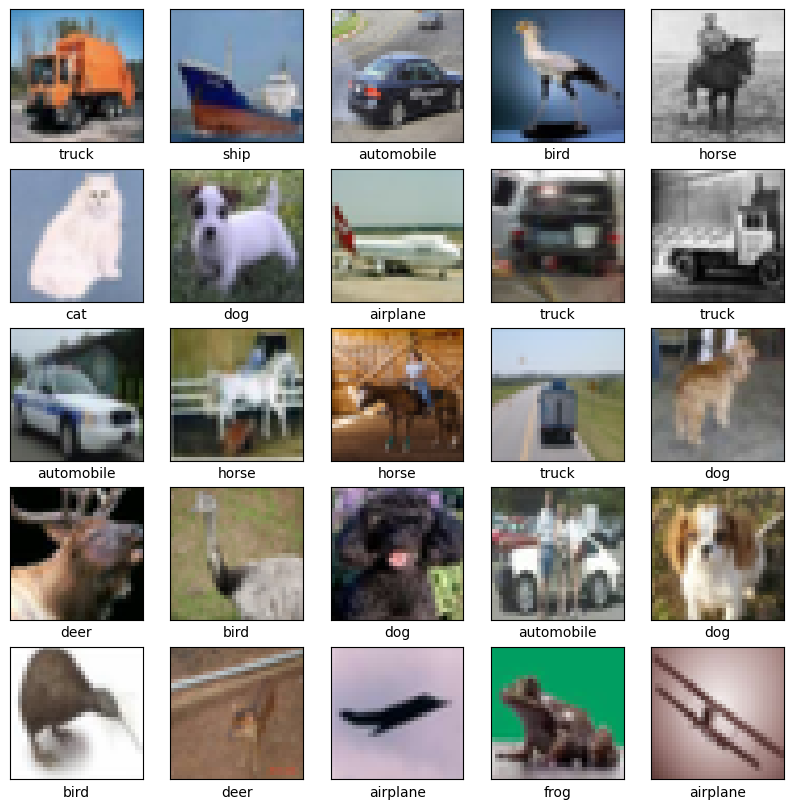

In [ ]:
# Plot 25 images from the training dataset with its labels
plt.figure(figsize=(10,10))
for i in range(25):
    index = np.random.randint(len(train_images)-5)+np.random.randint(4)
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[index])
    plt.xlabel(class_names[train_labels[index][0]])  # Take index number only
plt.show()

**STEP 1: Patch the input image**

Here I am assuming the patches are square shaped.

In [ ]:
class ImagePatcher(tf.keras.layers.Layer):
    def __init__(self, patch_height):
        super().__init__()
        self.patch_height = int(patch_height)

    def call(self, input_images):
        patches = tf.image.extract_patches(
            images=input_images,
            sizes=[1, self.patch_height, self.patch_height, 1],
            strides=[1, self.patch_height, self.patch_height, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patches = tf.cast(patches, tf.int32)

        # Calculate the sizes for reshaping
        height_of_patch = self.patch_height
        width_of_patch = self.patch_height

        number_of_images_in_the_batch = tf.cast(tf.shape(input_images)[0], tf.int32)
        number_of_patches_height_of_image = tf.cast(input_images.shape[1]//height_of_patch, tf.int32)
        number_of_patches_width_of_image = tf.cast(input_images.shape[2]//width_of_patch, tf.int32)
        no_of_channels = tf.cast(input_images.shape[3], tf.int32)

        number_of_patches_per_image = number_of_patches_height_of_image * number_of_patches_width_of_image
        size_of_one_patch = height_of_patch * width_of_patch * no_of_channels

        patches = tf.reshape(patches, shape=(number_of_images_in_the_batch, number_of_patches_per_image, size_of_one_patch))
        return patches

test_image_patches.shape[0] (Batch Size) = 10000
test_image_patches.shape[1] (Number of patches, N) = 64
test_image_patches.shape[2] (Length of one patch, P*P*C) = 48
truck


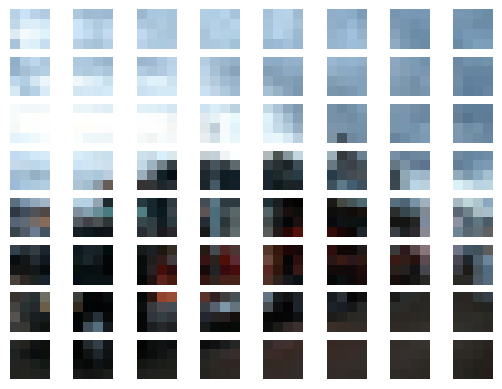

In [ ]:
# Here it shows one example of the patching procedure
patch_height = 4
test_image_patcher = ImagePatcher(patch_height=patch_height)
test_image_patches = test_image_patcher(test_images)

print(f"test_image_patches.shape[0] (Batch Size) = {test_image_patches.shape[0]}")
print(f"test_image_patches.shape[1] (Number of patches, N) = {test_image_patches.shape[1]}")
print(f"test_image_patches.shape[2] (Length of one patch, P*P*C) = {test_image_patches.shape[2]}")


count = 0
image_index_to_plot = np.random.randint(test_images.shape[0])
print(class_names[test_labels[image_index_to_plot][0]])
for i in np.arange(test_image_patches.shape[1]):
    ax = plt.subplot(test_images.shape[1]//patch_height, test_images.shape[1]//patch_height, count+1)
    plt.imshow(tf.reshape(test_image_patches[image_index_to_plot][count][:], shape = (4, 4, 3)))
    plt.axis("off")
    count += 1

plt.show()


**Step 2: Encode the patch**

* We convert the patch into a learnable latent vector, i.e. the hidden representation of the patches will be adjusted during the training.

* Also we add the position information of each patch along with the patch. For ex. top left patch is patch 1. So the number 1 is first converted to a learnable latent vector and then concatenated with the corresponding patch's learnable vector.

* An extra learnable vector "corresponding" to the class is added to the 0th position.

In [ ]:
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_of_patches, dim_of_projection):
        super().__init__()
        self.num_of_patches = num_of_patches
        self.dim_of_projection = dim_of_projection

        # Position index array including 0 for the class
        self.position_array = tf.keras.ops.arange(
            start=0, stop=num_of_patches+1, step=1, dtype=None
        )

        self.patches_to_vector = tf.keras.layers.Dense(
            units=dim_of_projection
        )
        self.postion_index_to_vector = tf.keras.layers.Embedding(
            input_dim=self.num_of_patches,
            output_dim=dim_of_projection
        )
        # Create embedding for class
        rand_gen_tensor = tf.random.Generator.from_seed(77)
        self.class_tokens = tf.Variable(
            initial_value=rand_gen_tensor.normal(shape=[1, 1, self.dim_of_projection])
        )



    def call(self, input_patches):
        # print(f"input_patches.shape ={input_patches.shape}")

        vectorized_patches = self.patches_to_vector(input_patches)
        vectorized_position = self.postion_index_to_vector(self.position_array)
        # print(f"vectorized_patches.shape = {vectorized_patches.shape}")
        # print(f"vectorized_position.shape = {vectorized_position.shape}")

        class_tokens_batch = tf.tile(self.class_tokens, [tf.shape(input_patches)[0], 1, 1])
        # print(f"self.class_tokens.shape = {self.class_tokens.shape}")
        # print(f"class_tokens_batch.shape = {class_tokens_batch.shape}")

        cat_class_token_and_vectorized_patches = tf.concat(
            values=[class_tokens_batch, vectorized_patches], axis=1
        )
        # print(f"cat_class_token_and_vectorized_patches.shape = {cat_class_token_and_vectorized_patches.shape}")

        return cat_class_token_and_vectorized_patches + vectorized_position

        # final_embedded_patch_and_position = vectorized_patches+vectorized_position
        # print(f"final_embedded_patch_and_position.shape = {final_embedded_patch_and_position.shape}")


In [ ]:
encode_the_patch = PatchEncoder(num_of_patches=test_image_patches.shape[1], dim_of_projection=768)
encoded_patch = encode_the_patch(test_image_patches)
encoded_patch.shape

TensorShape([10000, 65, 768])

**Step 3: The encoded patch is given to the transformer encoder block**

* We use `tf.keras.layers.LayerNormalization()` to do layer normalization before giving to Multiheaded self attention.[link text](https://)

* We use `tf.keras.layers.MultiHeadAttention` for implementing the transformer

* The Mutli Layer Perceptron (MLP) is used at the end of the transformer encoder is given below:

**The entire model is given below. The output from the 0th positon of the transformer is given to another MLP to do the classification task.**

In [ ]:
class MLP(tf.keras.Model):
    def __init__(self, first_layer_units=500, dim_of_projection=30):
        super().__init__()
        self.dense_layer_1 = tf.keras.layers.Dense(units=first_layer_units, activation="gelu")
        self.dropout_layer = tf.keras.layers.Dropout(rate=0.1)
        self.dense_layer_2 = tf.keras.layers.Dense(units=dim_of_projection, activation="gelu")

    def call(self, input):
        x = self.dense_layer_1(input)
        x = self.dropout_layer(x)
        x = self.dense_layer_2(x)
        return self.dropout_layer(x)

In [ ]:
class VitModel(tf.keras.Model):
    def __init__(self,
                 patch_height=4,
                 dim_of_projection=30,
                 num_of_patches=64,
                 number_of_transformer_layers=4,
                 number_of_transformer_heads=4,
                 number_of_classes=10):
        super().__init__()
        self.patch_height = patch_height
        self.image_patcher = ImagePatcher(patch_height=patch_height)
        self.encode_the_patch = PatchEncoder(num_of_patches=num_of_patches, dim_of_projection=dim_of_projection)

        self.layer_normalize = tf.keras.layers.LayerNormalization()
        self.number_of_transformer_layers = number_of_transformer_layers
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=number_of_transformer_heads,
                                                      key_dim=dim_of_projection,
                                                      value_dim=dim_of_projection)
        self.add = tf.keras.layers.Add()
        self.mlp = MLP(dim_of_projection=dim_of_projection)
        self.mlp_final_classification = tf.keras.Sequential()
        self.mlp_final_classification.add(tf.keras.layers.LayerNormalization())
        self.mlp_final_classification.add(tf.keras.layers.Dense(units=number_of_classes))

    def call(self, input_images):
        self.input_images = input_images

        image_patches = self.image_patcher(self.input_images)
        encoded_patch = self.encode_the_patch(image_patches)


        for iteration in np.arange(self.number_of_transformer_layers):
            # print(f"iteration = {iteration}")
            x1 = self.layer_normalize(encoded_patch)
            # print(f"x1.shape = self.layer_normalize(encoded_patch).shape = {x1.shape}")

            x2 = self.mha(query=x1, key=x1, value=x1) # If query, key, value are the same, then this is self-attention.
            # print(f"x2.shape = self.mha(x1) = {x2.shape}")

            zl_dash = self.add([x2, encoded_patch])
            # print(f"zl_dash.shape = self.add([x2, encoded_patch]) = {zl_dash.shape}")


            x3 = self.layer_normalize(zl_dash)
            x4 = self.mlp(x3)
            # print(f"x4.shape = self.mlp(x3)) = {x4.shape}")
            # print("\n")
            encoded_patch = self.add([x4, zl_dash])

        # print(f"encoded_patch.shape = {encoded_patch.shape}")
        return self.mlp_final_classification(encoded_patch[:,0,:]) # Eg take 1st row of each image patches



In [ ]:
vit = VitModel()
vit_op = vit(test_images)
print(f"vit_op.shape = {vit_op.shape}")

vit_op.shape = (10000, 10)


In [ ]:
vit.summary()

Model: "vit_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ image_patcher_14 (ImagePatcher)      │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patch_encoder_1 (PatchEncoder)       │ ?                           │           3,390 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization                  │ ?                           │              60 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ multi_head_attention                 │ ?                           │          14,790 │
│ (MultiHeadAttention)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ add (Add)                            │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mlp (MLP)                            │ ?                           │          30,530 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ ?                           │             370 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,140 (191.95 KB)

 Trainable params: 49,140 (191.95 KB)

 Non-trainable params: 0 (0.00 B)

**Load weights from training**

I trained my model on Free GColab TPU (ran 15 epochs) and CPU (ran another 5 epochs).

The code was not able to run in GColab GPU, since one tf.keras function (`tf.image.extract_patches`) was not optimized for GPU. I would like to later look at what to do with it.

In [ ]:
# Load weights
vit.load_weights("/content/epoch5_checkpoint.weights.h5")

In [ ]:
# Optimizer
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    weight_decay=0.01
)

# Loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True # Output from model is not a probability distribution
)

# Compile model
vit.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)



In [ ]:
# Evaluating on test dataset
vit.evaluate(x=test_images, y=test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.5398 - loss: 1.2683


[1.2606868743896484, 0.5436999797821045]

**I am getting an accuracy of ~54%**.

Let's see some predicitons.

In [ ]:
prediciton = vit(test_images)


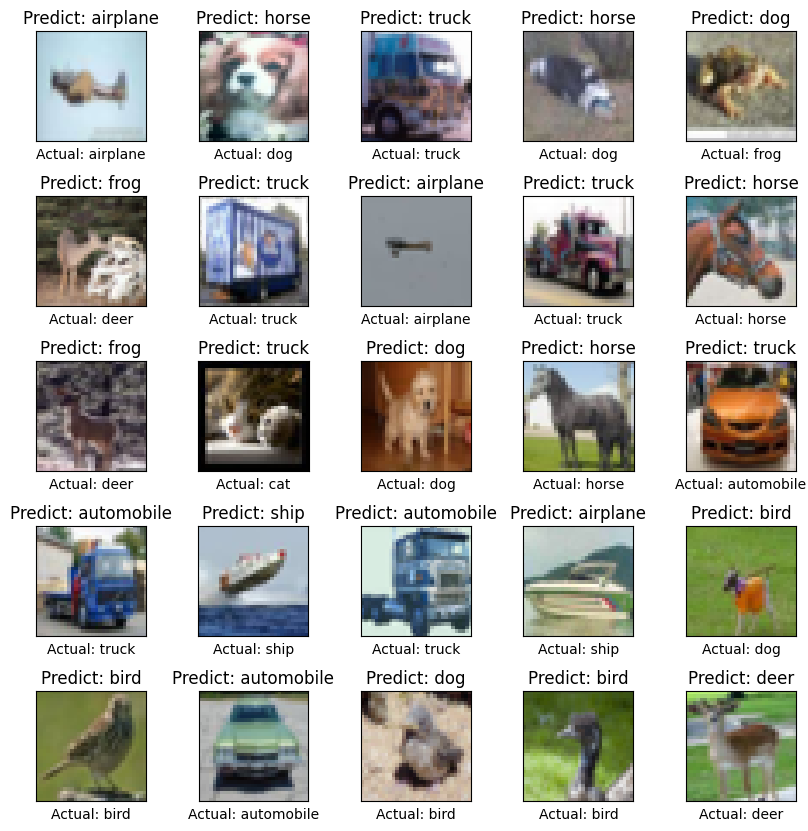

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    # Select an image randomly
    index = np.random.randint(len(test_images))

    # Convert the prediction of ViT Model
    # into probability distribution using softmax
    score = tf.nn.softmax(prediciton[index])

    # Convert index to predicted label
    predicted_label = class_names[np.argmax(score)]

    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[index])
    plt.title("Predict: "+str(predicted_label))
    plt.xlabel("Actual: "+class_names[test_labels[index][0]])  # Take index number only

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

**That's it.**

I am happy I could implement at least one paper.

**Code block which I used for training the model.**

In [ ]:
checkpoint_path = "tmp/ckpt/checkpoint.weights.h5"  # To save weights-file extension: weights.h5

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    verbose=0,
    save_best_only=False,
    save_weights_only=True,
    mode='max',
    save_freq='epoch',
    initial_value_threshold=None
)

history = vit.fit(
    x=train_images,
    y=train_labels,
    batch_size=300,
    epochs=5,
    validation_split=0.1,
    callbacks=[model_checkpoint_callback]
)